# Import

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Claas

In [8]:
class TeslaForecasting:
    def __init__(self, ticker="TSLA", start="2015-01-01", end=None):
        self.ticker = ticker
        self.start = start
        self.end = end or datetime.today().strftime("%Y-%m-%d")
        self.data = None
        self.prices = None
        self.scaler = MinMaxScaler()
        self.arima_model = None
        self.arima_fit = None
        self.lstm_model = None
        self.window = 60  # LSTM window size

    def fetch_data(self):
        print(f"Fetching data for {self.ticker}...")
        self.data = yf.download(self.ticker, start=self.start, end=self.end)
        self.prices = self.data['Close'].fillna(method='ffill')

    # ---------------- ARIMA ----------------
    def train_arima(self, order=(5,1,2)):
        print("Training ARIMA model...")
        self.arima_model = ARIMA(self.prices, order=order)
        self.arima_fit = self.arima_model.fit()

    def forecast_arima(self, steps=252):
        if not self.arima_fit:
            raise Exception("ARIMA model not trained yet.")
        forecast_result = self.arima_fit.get_forecast(steps=steps)
        forecast = forecast_result.predicted_mean
        conf_int = forecast_result.conf_int(alpha=0.05)  # 95% CI
        return forecast, conf_int

    # ---------------- LSTM ----------------
    def train_lstm(self, epochs=30, batch_size=32):
        print("Training LSTM model...")
        scaled_prices = self.scaler.fit_transform(self.prices.values.reshape(-1,1))

        X, y = self._create_sequences(scaled_prices, self.window)

        self.lstm_model = tf.keras.Sequential([
            tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(self.window, 1)),
            tf.keras.layers.LSTM(50),
            tf.keras.layers.Dense(1)
        ])
        self.lstm_model.compile(optimizer='adam', loss='mse')
        self.lstm_model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

    def forecast_lstm(self, steps=252):
        if not self.lstm_model:
            raise Exception("LSTM model not trained yet.")
        scaled_prices = self.scaler.transform(self.prices.values.reshape(-1,1))
        last_sequence = scaled_prices[-self.window:]
        preds = []

        for _ in range(steps):
            pred = self.lstm_model.predict(last_sequence.reshape(1, self.window,1), verbose=0)
            preds.append(pred[0,0])
            last_sequence = np.append(last_sequence[1:], pred, axis=0)

        preds = self.scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
        return preds

    def _create_sequences(self, data, window):
        X, y = [], []
        for i in range(len(data)-window):
            X.append(data[i:i+window])
            y.append(data[i+window])
        return np.array(X), np.array(y)

    # ------------- Visualization & Interpretation --------------

    def plot_forecasts(self, arima_forecast, arima_conf_int, lstm_forecast, forecast_days=252):
        last_date = self.prices.index[-1]
        future_dates = pd.date_range(
            start=last_date,
            periods=forecast_days+1,
            inclusive='right'   # use 'closed' instead of 'inclusive' for pandas < 1.4.0 compatibility
        )

        plt.figure(figsize=(14,7))
        plt.plot(self.prices[-forecast_days:], label='Historical Price', color='blue')

    # ARIMA forecast with CI
        plt.plot(future_dates, arima_forecast, label='ARIMA Forecast', color='red')
        plt.fill_between(future_dates,
                         arima_conf_int.iloc[:,0],
                         arima_conf_int.iloc[:,1],
                         color='red', alpha=0.3, label='ARIMA 95% Confidence Interval')

    # LSTM forecast
        plt.plot(future_dates, lstm_forecast, label='LSTM Forecast', color='green', linestyle='--')

        plt.title(f"{self.ticker} Stock Price Forecast (Next {forecast_days} Trading Days)")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()


    def analyze_trends(self, forecast_series):
        # Simple linear regression on forecast to detect trend slope
        x = np.arange(len(forecast_series))
        coeffs = np.polyfit(x, forecast_series, 1)
        slope = coeffs[0]
        trend = "upward" if slope > 0 else "downward" if slope < 0 else "stable"
        print(f"Trend Analysis: The forecast shows a {trend} trend with slope {slope:.4f}")
        return slope, trend

    def analyze_volatility(self, conf_int):
        # Width of confidence interval as volatility proxy
        widths = conf_int.iloc[:,1] - conf_int.iloc[:,0]
        print(f"Confidence Interval Width Stats:")
        print(f"- Min: {widths.min():.4f}")
        print(f"- Max: {widths.max():.4f}")
        print(f"- Mean: {widths.mean():.4f}")
        print(f"CI widths generally increase over time, indicating growing uncertainty in long-term forecasts.")
        return widths

    def summarize_opportunities_risks(self, slope, widths):
        print("\nMarket Opportunities and Risks:")
        if slope > 0:
            print("- Opportunity: Expected price increase suggests potential gains for investors.")
        else:
            print("- Risk: Expected price decline suggests caution.")

        if widths.iloc[-1] > widths.iloc[0]*2:
            print("- Risk: Increasing confidence interval width indicates higher forecast uncertainty over time.")
        else:
            print("- Forecast uncertainty remains relatively stable.")

# ---------------- USAGE -----------------


[*********************100%***********************]  1 of 1 completed

Fetching data for TSLA...
Training ARIMA model...


Training LSTM model...


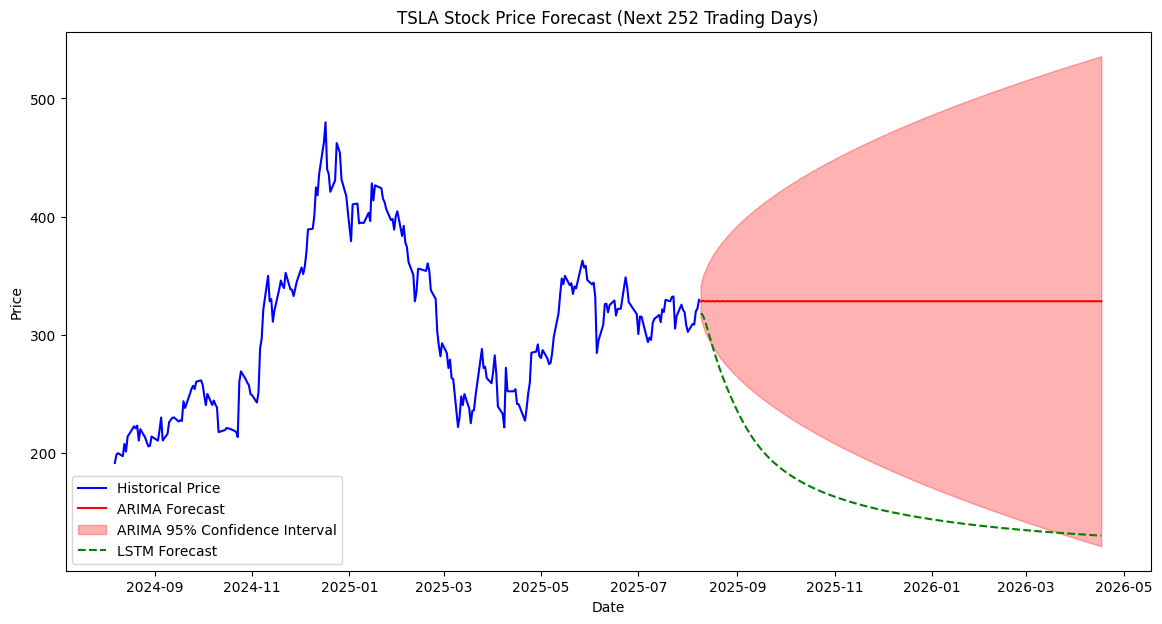

Trend Analysis: The forecast shows a downward trend with slope -0.0000
Confidence Interval Width Stats:
- Min: 26.7969
- Max: 414.3901
- Mean: 277.2247
CI widths generally increase over time, indicating growing uncertainty in long-term forecasts.

Market Opportunities and Risks:
- Risk: Expected price decline suggests caution.
- Risk: Increasing confidence interval width indicates higher forecast uncertainty over time.


In [9]:
if __name__ == "__main__":
    forecast_days = 252  # approx 1 year trading days

    forecaster = TeslaForecasting()
    forecaster.fetch_data()

    # Train and forecast with ARIMA
    forecaster.train_arima(order=(5,1,2))
    arima_forecast, arima_conf_int = forecaster.forecast_arima(steps=forecast_days)

    # Train and forecast with LSTM
    forecaster.train_lstm(epochs=20)
    lstm_forecast = forecaster.forecast_lstm(steps=forecast_days)

    # Plot combined forecast with confidence intervals
    forecaster.plot_forecasts(arima_forecast, arima_conf_int, lstm_forecast, forecast_days)

    # Analyze ARIMA trends and volatility
    slope, trend = forecaster.analyze_trends(arima_forecast)
    widths = forecaster.analyze_volatility(arima_conf_int)

    # Market opportunities and risks based on ARIMA forecast
    forecaster.summarize_opportunities_risks(slope, widths)